# Capstone Project 
## Part 1 - Predicting Airbnb rental prices

## Data cleaning - Dec 20 active listings

In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1.5)

date_scraped = datetime.datetime(2020, 12, 16)

In [2]:
# connect to database
db_user = 'postgres'
db_password = ''
db_host = 'localhost'
db_port = 5432
database = 'airbnb'

conn_str = f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{database}'
conn = psycopg2.connect(conn_str)

# load data for Dec 20 listings from database
df = pd.read_sql('SELECT * FROM dec20_listings', conn)
df.shape

(77136, 74)

### Clean up price
The price will be the target variable for the first part of the project. 
- Remove $ signs (it is actually quoted in £) and convert to a float
- Remove 22 rows with price = 0

In [3]:
def clean_price(string):
    string = string.replace('$', '').replace(',', '')
    return string

In [4]:
df.price = df.price.map(clean_price).astype(float)
# drop rows with price = £0
df = df[df.price != 0]

### Active listings
For this analysis we will only consider active listings since inactive listings are likely to have unreliable data. Unfortunately there is no easy way to define active listings from the data. 

We will assume that for a listing to be active:
1. It must have been reviewed in the last 12 months
2. It must have at least two nights booked in the next 90 days

In [5]:
print('Count of listings with 90 day availability = 90:', (df.availability_90 == 90).sum())
print('Count of listings with 90 day availability = 89:', (df.availability_90 == 89).sum())
print('Count of listings with 90 day availability = 88:', (df.availability_90 == 88).sum())

Count of listings with 90 day availability = 90: 10633
Count of listings with 90 day availability = 89: 6398
Count of listings with 90 day availability = 88: 2905


In [6]:
# subset on listings which have been reviewed in the last 12 months
df = df[df.number_of_reviews_ltm > 0]
# subset on listings which have at least two nights booked in the next 90 days
df = df[df.availability_90 < 89]
df.shape

(21055, 74)

### Drop redundant columns and rows
- Drop 11 rows with no information on the host.
- Drop 4 columns with all null values (`neighbourhood_group_cleansed`, `bathrooms`, `calendar_updated`, `license`).

In [7]:
# drop rows with no host info
df.dropna(subset=['host_name'], inplace=True)
# drop 4 columns with all null values
df.drop(columns=['neighbourhood_group_cleansed', 'bathrooms', 'calendar_updated', 'license'], inplace=True)

### Property type vs room type
- `room_type` looks more useful than `property_type` which contains many categories, many of which have few occurrences. 
- Consider NLP for `property_type` to see if we can extract useful information which is not included in `room_type` (see EDA).

In [8]:
df.room_type.value_counts()

Entire home/apt    13635
Private room        7162
Hotel room           165
Shared room           82
Name: room_type, dtype: int64

In [9]:
df.property_type.value_counts()[:10]

Entire apartment               10683
Private room in apartment       3448
Private room in house           2507
Entire house                    1474
Private room in townhouse        500
Entire condominium               442
Entire townhouse                 327
Entire serviced apartment        230
Entire loft                      166
Private room in condominium      149
Name: property_type, dtype: int64

### Bathroom data
- The column `bathrooms_text` contains strings such as '1.5 shared baths'. Create two new columns based on this - one with a numeric number of bathrooms and one with the type (private or shared).
- Impute data for missing values:
 - For listings where the `room_type` is private room or shared room, assume 1 shared bath.
 - For listings where the `room_type` is entire home/apt (only 1 listing), assume 1 private bath.

In [10]:
df.bathrooms_text.value_counts().head()

1 bath            9227
1 shared bath     3099
2 baths           2637
1 private bath    1631
1.5 baths         1551
Name: bathrooms_text, dtype: int64

In [11]:
# extract number of bathrooms from bathrooms_text to create new feature for modelling
def number_of_bathrooms(string):
    try:
        num = re.findall(r'(\d+\.*\d*)', string)
        if len(num) == 1:
            return float(num[0])
        elif len(num) == 0 and 'half' in string.lower():
            return 0.5
        else:
            return np.nan
    except:
        return np.nan

In [12]:
df['number_bathrooms'] = df.bathrooms_text.map(number_of_bathrooms)

In [13]:
# extract bathroom type (shared or private) from bathrooms_text to create new feature for modelling
def private_bathroom(string):
    try:
        if 'shared' in string.lower():
            return 0
        else:
            return 1
    except:
        return np.nan

In [14]:
df['private_bathroom'] = df.bathrooms_text.map(private_bathroom)

In [15]:
df[df.number_bathrooms.isnull()].room_type.value_counts()

Private room       7
Shared room        3
Entire home/apt    1
Name: room_type, dtype: int64

In [16]:
# impute missing values
df.number_bathrooms.fillna(1.0, inplace=True)
df.loc[(df.room_type == 'Private room') & (df.private_bathroom.isnull()) , 'private_bathroom'] = 0
df.loc[(df.room_type == 'Shared room') & (df.private_bathroom.isnull()) , 'private_bathroom'] = 0
df.loc[(df.room_type == 'Entire home/apt') & (df.private_bathroom.isnull()) , 'private_bathroom'] = 1
df.private_bathroom = df.private_bathroom.astype(int)
df.private_bathroom.value_counts(normalize=True)

1    0.772952
0    0.227048
Name: private_bathroom, dtype: float64

### Bedrooms
- `accommodates`, `beds` and `bedrooms` are closely linked.
- `accommodates` has no missing values, but `beds` and `bedrooms` both have some missing values.
- Impute missing values for `beds` and `bedrooms` using a simple linear regression with `accommodates` as the predictor.

In [17]:
print('Null values in bedrooms: ', df.bedrooms.isnull().sum())
print('Null values in beds: ', df.beds.isnull().sum())
print('Null values in both bedrooms and beds: ', (df.bedrooms.isnull() & df.beds.isnull()).sum())

Null values in bedrooms:  1349
Null values in beds:  168
Null values in both bedrooms and beds:  11


In [18]:
# use linear regression to predict beds from accommodates
y = df[df.beds.notnull()].beds
X = df[df.beds.notnull()][['accommodates']]
lr1 = LinearRegression(fit_intercept=True)
lr1.fit(X, y)
print('Model score:', lr1.score(X, y))
lr1.coef_, lr1.intercept_

Model score: 0.671260504404837


(array([0.5377622]), 0.023810381586908846)

In [19]:
# use linear regression to predict bedrooms from accommodates
y = df[df.bedrooms.notnull()].bedrooms
X = df[df.bedrooms.notnull()][['accommodates']]
lr2 = LinearRegression(fit_intercept=True)
lr2.fit(X, y)
print('Model score:', lr2.score(X, y))
lr2.coef_, lr2.intercept_

Model score: 0.6428857397756884


(array([0.34078598]), 0.3711961621405697)

In [20]:
def impute_from_accommodates(df, col, model):
    '''
    Function to impute missing values in a column based
    on a simple linear regression model using the accommodates
    feature as the predictor variable
    '''
    if np.isnan(df[col]):
        try:
            return round(model.intercept_ + model.coef_[0] * df['accommodates'], 0)
        except:
            return np.nan
    else:
        return df[col]

In [21]:
df['number_beds'] = df.apply(impute_from_accommodates, col='beds', model=lr1, axis=1)
df['number_bedrooms'] = df.apply(impute_from_accommodates, col='bedrooms', model=lr2, axis=1)
df['number_beds'] = df['number_beds'].astype(int)
df['number_bedrooms'] = df['number_bedrooms'].astype(int)

### Host listings count

In [22]:
# data contains some instances of zero
# check against calculated_host_listings_count (overall less accurate) - makes sense to replace 0 with 1
df.host_listings_count.value_counts().head()

1.0    7106
2.0    3234
0.0    2759
3.0    1549
4.0     880
Name: host_listings_count, dtype: int64

In [23]:
# replace 0 values in host_listings_count with 1
df.host_listings_count.replace(0, 1, inplace=True)
# convert to integer (from float)
df.host_listings_count = df.host_listings_count.astype(int)

### Binary variables
- Convert binary variables (t, f) to (1, 0) for modelling
- Check proportions

In [24]:
# function to create binary variables from existing format of (t, f)
def binarize(string):
    if string == 't':
        return 1
    elif string == 'f':
        return 0
    else:
        return np.nan

In [25]:
df.host_is_superhost = df.host_is_superhost.map(binarize)
df.host_is_superhost.value_counts(normalize=True)

0    0.698109
1    0.301891
Name: host_is_superhost, dtype: float64

In [26]:
df.host_identity_verified = df.host_identity_verified.map(binarize)
df.host_identity_verified.value_counts(normalize=True)

1    0.859627
0    0.140373
Name: host_identity_verified, dtype: float64

In [27]:
df.instant_bookable = df.instant_bookable.map(binarize)
df.instant_bookable.value_counts(normalize=True)

0    0.618561
1    0.381439
Name: instant_bookable, dtype: float64

In [28]:
# drop has_availability as is true in 99.8% of listings so will have no predictive power
df.has_availability = df.has_availability.map(binarize)
df.has_availability.value_counts(normalize=True)

1    0.997957
0    0.002043
Name: has_availability, dtype: float64

### Amenities
The `amenities` feature contains a list of amenities for each listing. We will need to use NLP to extract useful information for modelling.

In [29]:
df.amenities[0]

'["Refrigerator", "Kitchen", "Crib", "Dedicated workspace", "Lockbox", "Stove", "Carbon monoxide alarm", "Iron", "Cable TV", "Wifi", "Long term stays allowed", "Fire extinguisher", "Smoke alarm", "Hot water", "Heating", "Paid parking off premises", "Washer", "Essentials", "High chair", "TV", "Hangers", "Coffee maker", "Oven", "Pack \\u2019n Play/travel crib", "Hair dryer", "Microwave", "Cooking basics", "Dishes and silverware"]'

In [30]:
# use CountVectorizer to inspect the words in the amenities column
cvec = CountVectorizer(token_pattern='(?u)[a-zA-Z][a-z ]+',
                       ngram_range=(1,1))
cmat = cvec.fit_transform(df.amenities)

In [31]:
# look at 10 most frequently occurring words/phrases
pd.DataFrame(np.array(cmat.sum(axis=0))[0],
             index=cvec.get_feature_names(), columns=['counts']).sort_values('counts', ascending=False)[:10]

,counts
wifi,20658
heating,20486
essentials,20318
smoke alarm,19514
kitchen,19023
hangers,18597
washer,18309
iron,18179
hair dryer,17423
hot water,16796


### Availability
- `availability_30`, `availability_60` and `availability_90` are very highly correlated
- Consider using only `availability_90` and `availability_365` for modelling

In [32]:
df[['availability_30', 'availability_60', 'availability_90', 'availability_365']].corr()

,availability_30,availability_60,availability_90,availability_365
availability_30,1.000000,0.910308,0.822614,0.488385
availability_60,0.910308,1.000000,0.967593,0.613217
availability_90,0.822614,0.967593,1.000000,0.682082
availability_365,0.488385,0.613217,0.682082,1.000000


### Host info

#### `host_since`
This is a date - convert into number of days for modelling.

In [33]:
# calculate how long host for in days for modelling
df['host_since_days'] = df.host_since.map(lambda x: (date_scraped - pd.to_datetime(x)).days)

#### `host_response_time`
This is a categorical variable. Replace missing values with 'unknown'.

In [34]:
# replace missing values with 'unknown' (categorical variable)
df.host_response_time.fillna('unknown', inplace=True)
df.host_response_time.value_counts(normalize=True)

within an hour        0.425727
unknown               0.285497
within a few hours    0.146455
within a day          0.112906
a few days or more    0.029415
Name: host_response_time, dtype: float64

#### `host_response_rate` and `host_acceptance_rate`
Many missing values - convert these to 'unknown'. Group the numerical % values into bins so these can be treated as categorical variables.

In [35]:
# function to create bins from a numerical variable with missing values
def create_bins(df, col, bins, labels, na_label):
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype(str)
    df[col].replace(np.nan, na_label, inplace=True)

In [36]:
# convert host_response_rate to bins and replace missing values with 'unknown' (treat as categorical variable)
df.host_response_rate = df.host_response_rate.str.strip('%').astype(float)
# create four bins
bins = [0, 49, 89, 99, 100]
labels = ['0-49%', '50-89%', '90-99%', '100%']
create_bins(df, 'host_response_rate', bins, labels, 'unknown')
df.host_response_rate.value_counts()

100%       10735
unknown     6008
50-89%      1898
90-99%      1792
0-49%        611
Name: host_response_rate, dtype: int64

In [37]:
# convert host_acceptance_rate to bins and replace missing values with 'unknown' (treat as categorical variable)
df.host_acceptance_rate = df.host_acceptance_rate.str.strip('%').astype(float)
# create four bins
bins = [0, 49, 89, 99, 100]
labels = ['0-49%', '50-89%', '90-99%', '100%']
create_bins(df, 'host_acceptance_rate', bins, labels, 'unknown')
df.host_acceptance_rate.value_counts()

100%       8501
90-99%     5481
50-89%     5230
unknown     967
0-49%       865
Name: host_acceptance_rate, dtype: int64

### Reviews

In [38]:
# keep all 3 number_of_reviews features as not highly correlated
df[['price', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d']].corr()

,price,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d
price,1.000000,-0.069275,-0.058019,-0.022478
number_of_reviews,-0.069275,1.000000,0.469951,0.047508
number_of_reviews_ltm,-0.058019,0.469951,1.000000,0.301649
number_of_reviews_l30d,-0.022478,0.047508,0.301649,1.000000


#### `first_review` and `last_review`
Convert `first_review` and `last_review` dates to number of days.

In [39]:
# function to calculate the number of days since data scraped
# some review dates are after the date scraped (by a few days), assume 0 days for these
def calculate_days(date):
    try:
        return max((date_scraped - pd.to_datetime(date)).days, 0)
    except:
        return np.nan

In [40]:
df['first_review_days'] = df.first_review.map(calculate_days)
df['last_review_days'] = df.last_review.map(calculate_days)

#### `reviews_per_month`

In [41]:
# for reviews_per_month replace null values with 0
df.reviews_per_month.fillna(0, inplace=True)

#### `review_scores` (several features)
Some missing values presumably reflecting listings which were reviewed but did not have ratings given. Two possible ways to treat this:
- Treat the scores as categorical variables with a category for 'no ratings' (for this approach, bins will need to be created for the rating score)
- Impute scores for the listings which do not have ratings (based on mean, median or mode scores)    

Since only 87 listings have missing values, I will impute the scores for these listings using the median. NB the scores tend to be very positive (mode = median = 10 (out of 10) for all categories except the rating which is out of 100).

In [42]:
review_scores_cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                     'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
                     'review_scores_value']
df[review_scores_cols].describe()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
count,20957.000000,20942.000000,20942.000000,20942.000000,20942.000000,20942.000000,20942.000000
mean,93.819249,9.606819,9.392799,9.705234,9.715882,9.653376,9.375322
std,8.905774,0.869679,0.991941,0.790125,0.798185,0.728212,0.927329
min,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,91.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000
50%,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
75%,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
max,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


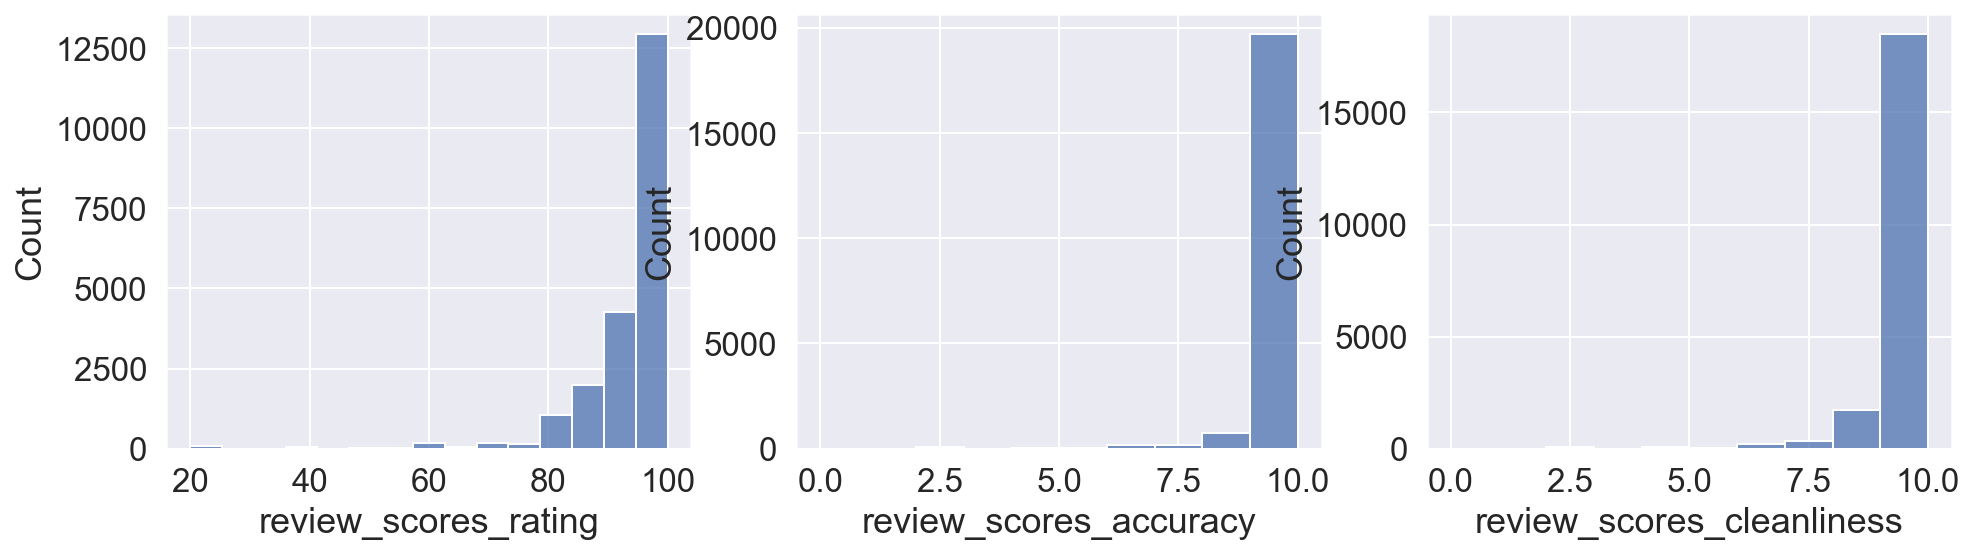

In [43]:
fig, ax = plt.subplots(ncols=3, figsize=(16, 4))
sns.histplot(df.review_scores_rating, ax=ax[0], bins=15)
sns.histplot(df.review_scores_accuracy, ax=ax[1], bins=np.linspace(0, 10, 11))
sns.histplot(df.review_scores_cleanliness, ax=ax[2], bins=np.linspace(0, 10, 11))
plt.show()

In [44]:
# function to impute median
def impute_median(col):
    median = df[col].median()
    df[col].fillna(median, inplace=True)

In [45]:
for col in review_scores_cols:
    impute_median(col)

### Further data cleaning
After inspection of outliers in the data e.g. properties with a high number of bathrooms, some further cleaning is necessary - see details below.

In [46]:
# the description for this property states 2 bedrooms, not 10 - correct value
df.loc[66877][['name', 'description', 'number_bathrooms', 'number_bedrooms']]

name                  Superb Two Bedroom Apartment Near Regent's Park
description         This modern two bedroom apartment offers the h...
number_bathrooms                                                  2.0
number_bedrooms                                                    10
Name: 66877, dtype: object

In [47]:
df.loc[66877, 'number_bedrooms'] = 2

In [48]:
# the description for this property states 1 bedroom, not 8 - correct value
df.loc[10165][['name', 'description', 'number_bathrooms', 'number_bedrooms']]

name                                               Putney modern flat
description         Spacious cozy newly refurbished modern 1-bedro...
number_bathrooms                                                  1.5
number_bedrooms                                                     8
Name: 10165, dtype: object

In [49]:
df.loc[10165, 'number_bedrooms'] = 1

In [50]:
# the description for this property states 1 bedroom, not 8 - correct value
df.loc[63608][['name', 'description', 'number_bathrooms', 'number_bedrooms']]

name                Stunning One Bedroom Apartment In Prime Maryle...
description         This stunning One Bedroom Apartment features a...
number_bathrooms                                                  1.0
number_bedrooms                                                     8
Name: 63608, dtype: object

In [51]:
df.loc[63608, 'number_bedrooms'] = 1

The host 'Palmers Lodge' has multiple listings for rooms in a hostel. Information entered very inconsistently e.g. 10 bathrooms for a dorm room. Remove inactive listings (availability_90 = 0) and correct obvious mistakes in the remaining ones.

In [52]:
indices = df[(df.host_name == 'Palmers Lodge') & (df.availability_90 == 0)].index
df.drop(index=indices, inplace=True)

In [53]:
for i in df[df.host_name == 'Palmers Lodge'].index:
    df.loc[i, 'number_bathrooms'] = 1.0
    df.loc[i, 'private_bathroom'] = 0

There are some hosts which have multiple listings for rooms in a hostel / beds in a dorm room. Information entered very inconsistently e.g. 10 bathrooms for a dorm room. Correct obvious mistakes in the listings.

In [54]:
mask = (df.host_name == 'Safestay') & (df.room_type == 'Shared room')
for i in df[mask].index:
    df.loc[i, 'accommodates'] = 1

In [55]:
mask = (df.number_bathrooms >= 7) & (df.host_name == 'Gareth')
for i in df[mask].index:
    df.loc[i, 'number_bathrooms'] = 1.0
    df.loc[i, 'accommodates'] = 1

In [56]:
mask = (df.room_type == 'Shared room') & (df.accommodates > 2) & (df.host_name == 'Richard')
for i in df[mask].index:
    df.loc[i, 'number_bathrooms'] = 1.0
    df.loc[i, 'accommodates'] = 1

In [57]:
mask = (df.room_type == 'Shared room') & (df.accommodates > 2) & (df.host_name == 'Marian')
for i in df[mask].index:
    df.loc[i, 'number_bathrooms'] = 1.0
    df.loc[i, 'accommodates'] = 1

In [58]:
mask = (df.room_type == 'Shared room') & (df.accommodates > 2) & (df.host_name.str.contains('Astor'))
for i in df[mask].index:
    df.loc[i, 'accommodates'] = 1

In [59]:
mask = (df.room_type == 'Shared room') & (df.accommodates > 2) & (df.name.str.contains('PubLove'))
for i in df[mask].index:
    df.loc[i, 'accommodates'] = 1

In [60]:
# listings for multiple properties in one - drop as price not quoted consistently
# first one is an office space, not for overnight stays
# drop host City Living - agency which seems to have set its prices very high to prevent bookings i.e. not active
indices_to_drop = [67725, 15044, 60728, 58369, 11823, 65312, 38052, 30829, 56143, 56744, 50792, 14293, 43388, 33634, 70785]
df.drop(index=indices_to_drop, inplace=True)

In [61]:
# host STK Homes seems to have very similar listings with very different prices - drop this host as data is unreliable
df = df[df.host_name != 'STK Homes']

### Save clean data to CSV for EDA
Drop all remaining columns redundant for modelling e.g. ones which contain URLs.

In [62]:
# create separate dataframe with longitude and latitude coordinates
df_geo = df[['id', 'price', 'neighbourhood_cleansed', 'longitude', 'latitude']].copy()
df_geo.shape

(20994, 5)

In [63]:
# write geographical data to CSV
df_geo.to_csv('../GA/capstone-data-airbnb/dec20-data/active_listings_geo.csv')

In [64]:
# drop redundant columns
df.drop(columns=['listing_url', 'scrape_id', 'last_scraped', 'picture_url', 
                 'host_id', 'host_url', 'host_location', 'host_about', 'host_thumbnail_url', 
                 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 
                 'neighbourhood', 'calendar_last_scraped', 'calculated_host_listings_count_entire_homes', 
                 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 
                 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 
                 'minimum_maximum_nights', 'maximum_maximum_nights', 'longitude', 'latitude',
                 'bathrooms_text', 'beds', 'bedrooms', 'host_total_listings_count', 
                 'calculated_host_listings_count', 'has_availability',
                 'host_since', 'first_review', 'last_review'], inplace=True)

In [65]:
# write clean data to CSV
df.to_csv('../GA/capstone-data-airbnb/dec20-data/active_listings_clean.csv')
df.shape

(20994, 42)